# Assignment Living skin detection # 


## Authors: Jan Zahn, Jonas Meier, Thomas Wiktorin ##

## Task ##

Train a classifier which is able to distinguish between living and dead materials with highest success rate
The used NN should have few most distinctive input features i.e. spectral lines

Steps:

Read all XLS and CSV data files into Python.  
Visualize them and based on your insight suggest / try some decent feature classifiers.  
Select them, train them and validate them.  
Analyse runtime and memory footprint.  
Argue why your solution is appropriate.  

EXTENSION :
please implement and compare the "Living Skin" detection using  MLP and  SVMs and radial basis functions RBFs.  
Imporant metrics are especailly confusion-matrix, precsion and recall, many more may be runtime, memory foot step  
Train time etc  


## Explanation:##

BUG NOTE: We shuffle the data to get a normalised distribution of datatypes. Sometimes the random shuffle does not shuffle the the data-matrix and class-matrix the same way order, resulting in an unusable model with 50% accuraxy. If this happens, re-run the program.

In our first program we chose to use all 121 values on the input layer, and see how accurate our model is. We reached over 96 percent accuracy consistently. Using different sizes of epochs/batch_size/validation data/training data/test data/hidden layers did not change our results in huge ways. However, I believe the size of the hidden layers is better to be small due to overfitting.   

One problem existed in the unequal representation of classes. The "living Material" has just 6 examples, while the other class is represented by 171 data sets. To reach a high accuracy, our model just classified everything as "dead material" and had instant high training and validation accuracy. Of course, this accuracy is meaningless, since we are often interested in the under represented class.  

At first, we tried to weight our examples by the means of sensitivity and specificity.  

sensitivity = true positives / positives  
specificity = true negatives / negatives  

Our model always predicts dead material and therefore has a sensitivity of 0 and specificity of 1.  
We want to achieve a model that gets close to both sensitivity and specificity beeing 1.  

Weighting did not fix our issues, so we increased the number of positive examples by duplicating them, until the numbers for each class were equal.  
This fixed our issue and we got high accuracy (>95%) and a sensitivity & specificity value close to 1.

In the second program we reduced our number of features, otherwise it is the same. 
We reduced the input layer from 121 to 12.

We looked at the second derivative and the concavity (see program 2 graphs) seemed to provide a few distinct values, important for our few features. We chose the points where the second derivative is in its extremes for both min and max, resulting in a total of 12 points.   
This resulted in a higher accuracy (>98%) and a more stable learning (see last graphs in program two)  

Runtime for an prediction of our model with 12 features takes:  
0.0001302809675962635 seconds  
And with 121:  
0.0001329888860936989 seconds  
  
340 evaluations with 121 features take:  
0.00032795901779536507 seconds  
  
340 evaluations with 12 features take:  
0.000109520259115925  

We get a slight improvement, but with our data and network size, runtime and memory does not seem to matter much.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import csv

#-------------------------------------------------------------------------------Get Data
dataFilesOldNegatives = ["Fleisch", "Holz", "Leder", "Stoff"]
dataFilesOldPositives = ["Referenz-Haut_6-Klassen"]

dataFilesNewNegatives = ["2016material", "2016material-fake"]
dataFilesNewPositives = ["2016skin"]

def importData(fileNames):
    data = np.array([]);
    xPoints = np.array([]);
    for dataType in fileNames:
        with open("Archiv\\" + dataType + '.csv', mode='r') as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=';')
                
                newList = list(csv_reader)      
                for index, row in enumerate(newList):
                   newList[index] = [value.replace(',', '.') for value in row]
                
                newData = np.asarray(newList)
                newData = np.delete(newData, (0), axis=0)
                if xPoints.size == 0:
                    xPoints = newData[:,0]
                newData = np.delete(newData,(0), axis=1)
                
                if data.size == 0:
                    data = newData.transpose()
                else:
                    data = np.append(data, newData.transpose(),axis=0)
    
        data = data.astype(np.float)
        xPoints =  xPoints.astype(np.float)    
    return xPoints, data 


#Negatives Old
xValuesOld, dataNegativesOld = importData(dataFilesOldNegatives)

#Positives Old
_, dataPositivesOld = importData(dataFilesOldPositives)

#Negatives New
xValuesNew, dataNegativesNew = importData(dataFilesNewNegatives)

#Positives New
_, dataPositivesNew = importData(dataFilesNewPositives)

#Increase positives to deal with unbalance class (maybe not needed with 2016 set)
# dataPositives = np.tile(dataPositivesOld,(28,1)) 

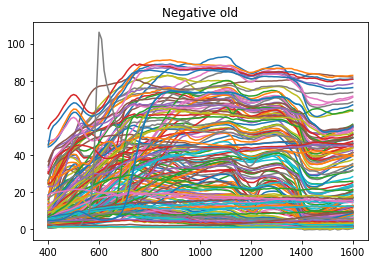

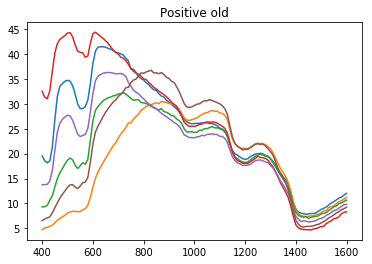

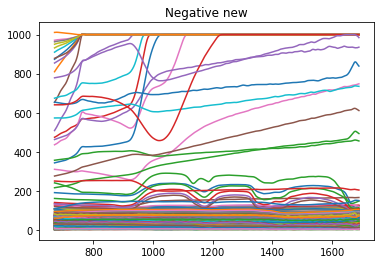

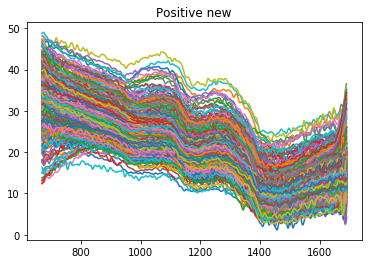

In [2]:
#--------------------------------------------------------------------------------Plott Data
def plottSpectrals(x,y,z, format=""):
    for row in y:
        plt.plot(x,row, format)
    plt.title(z)
    plt.show()
        
plottSpectrals(xValuesOld,dataNegativesOld, "Negative old")
plottSpectrals(xValuesOld,dataPositivesOld, "Positive old")
plottSpectrals(xValuesNew,dataNegativesNew, "Negative new")
plottSpectrals(xValuesNew,dataPositivesNew, "Positive new")

In [3]:
#--------------------------------------------------------------------------------Some Information on Data
print("Old xValue data: " + str(xValuesOld.shape))
print("Old negative data: " + str(dataNegativesOld.shape))
print('Old positive data: ' + str(dataPositivesOld.shape))
print("New xValue data: " + str(xValuesNew.shape))
print('New negative data: ' + str(dataNegativesNew.shape))
print('New positive data: ' + str(dataPositivesNew.shape))


Old xValue data: (121,)
Old negative data: (171, 121)
Old positive data: (6, 121)
New xValue data: (1031,)
New negative data: (367, 1031)
New positive data: (1111, 1031)


In [4]:
#---------------------------------------------------------------------------------Combine different Data
#Old wavelength 400-1600 ;                           in steps of 10
#New wavelength 670-1690 (everything after is NaN);  in steps of 1 

#Delete NaN at the end of new files
dataNegativesNew = dataNegativesNew[:,:xValuesNew.size-10]
dataPositivesNew = dataPositivesNew[:,:xValuesNew.size-10]
xValuesNew = xValuesNew[:xValuesNew.size-10]

#InterpolateOldData to match new 
tmp_positive_old = np.empty((len(dataPositivesOld),1200))
tmp_negative_old = np.empty((len(dataNegativesOld),1200))
xValuesAlteredOld = np.asarray(range(400,1600))

for i in range(len(dataPositivesOld)):
    tmp_positive_old[i,:] = np.interp(xValuesAlteredOld,xValuesOld,dataPositivesOld[i,:])

for i in range(len(dataNegativesOld)):
    tmp_negative_old[i,:] = np.interp(xValuesAlteredOld,xValuesOld,dataNegativesOld[i,:])

In [5]:
#---------------------------------------------------------------------------------Print new data format

xValuesOld = xValuesAlteredOld
dataNegativesOld = tmp_negative_old
dataPositivesOld = tmp_positive_old

print("After interpolation:")
print("Old negative data: " + str(dataNegativesOld.shape))
print('Old positive data: ' + str(dataPositivesOld.shape))
print('New negative data: ' + str(dataNegativesNew.shape))
print('New positive data: ' + str(dataPositivesNew.shape))

After interpolation:
Old negative data: (171, 1200)
Old positive data: (6, 1200)
New negative data: (367, 1021)
New positive data: (1111, 1021)


In [6]:
#---------------------------------------------------------------------------------Cut off old data to match new data

dataNegativesOld = dataNegativesOld[:,int(xValuesNew[0]-xValuesOld[0]):]
dataPositivesOld = dataPositivesOld[:,int(xValuesNew[0]-xValuesOld[0]):]
dataNegativesNew = dataNegativesNew[:,:int(xValuesOld[xValuesOld.size-1]-xValuesNew[0])+1]
dataPositivesNew = dataPositivesNew[:,:int(xValuesOld[xValuesOld.size-1]-xValuesNew[0])+1]

xValuesOld = np.asarray(range(670,1600))
xValuesNew = xValuesOld

In [7]:
#---------------------------------------------------------------------------------Print new data format

print("After cutting:")
print("Old negative data: " + str(dataNegativesOld.shape))
print('Old positive data: ' + str(dataPositivesOld.shape))
print('New negative data: ' + str(dataNegativesNew.shape))
print('New positive data: ' + str(dataPositivesNew.shape))

After cutting:
Old negative data: (171, 930)
Old positive data: (6, 930)
New negative data: (367, 930)
New positive data: (1111, 930)


Average value of all measurements is 40.68300664288945


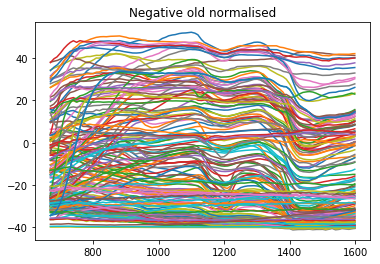

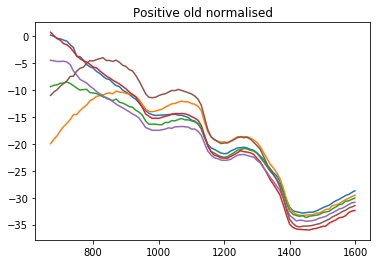

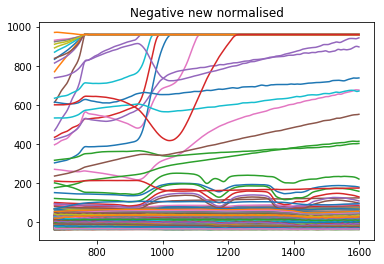

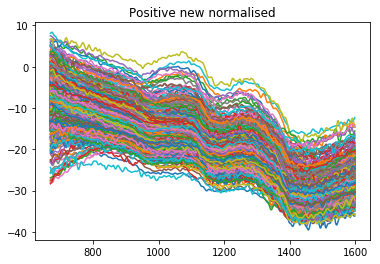

In [8]:
# Normalisation of ys over all data

# Stores average value of each measure
avg = []
for dataSet in [dataNegativesOld, dataPositivesOld, dataNegativesNew, dataPositivesNew]:
    for measure in dataSet:
        # Average for each measure
        avg.append(np.average(measure))
avg = np.average(avg)
print("Average value of all measurements is", avg)

# Use average to normalise data
for dataSet in [dataNegativesOld, dataPositivesOld, dataNegativesNew, dataPositivesNew]:
    for index, measure in enumerate(dataSet):
        # Average for each measure
        dataSet[index] = measure - avg

#--------------------------------------------------------------------------------Plott Data        
plottSpectrals(xValuesOld,dataNegativesOld, "Negative old normalised")
plottSpectrals(xValuesOld,dataPositivesOld, "Positive old normalised")
plottSpectrals(xValuesNew,dataNegativesNew, "Negative new normalised")
plottSpectrals(xValuesNew,dataPositivesNew, "Positive new normalised")

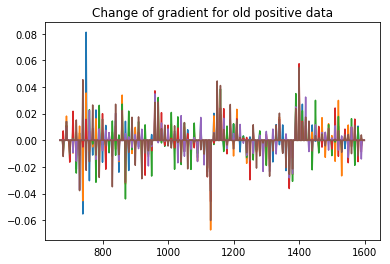

In [9]:
#---------------------------------------------------------------------------------New Features
#Extra Value for less Features (maybe)
# GradientData = 2nd derivation of input data
gradientData_old = np.empty([dataPositivesOld.shape[0],dataPositivesOld.shape[1]]);
i = 0;
for row in dataPositivesOld:
    gradient = np.gradient(np.gradient(row)) #where does the gradient change fastest
    plt.plot(xValuesOld,gradient)
    gradientData_old[i] = gradient
    i += 1
    
plt.title("Change of gradient for old positive data")
plt.show()

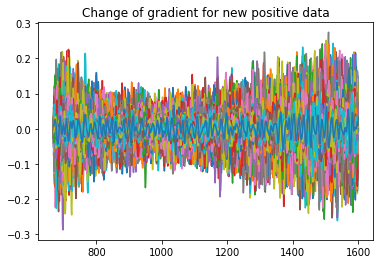

In [10]:
#---------------------------------------------------------------------------------New Features
#Extra Value for less Features (maybe)
# GradientData = 2nd derivation of input data
gradientData_new = np.empty([dataPositivesNew.shape[0],dataPositivesNew.shape[1]]);
i = 0;
for row in dataPositivesNew:
    gradient = np.gradient(np.gradient(row)) #where does the gradient change fastest
    plt.plot(xValuesOld,gradient)
    gradientData_new[i] = gradient
    i += 1
    
plt.title("Change of gradient for new positive data")
plt.show()

Wavelengths to use for further operations: [  8  15  28  35  55  56  63  85 114 159 241 489 490 595 626 652 656 671
 693 700 752 768 821 822 826 850 863 865 866 913] nm.
In total:  30  wavelengths.


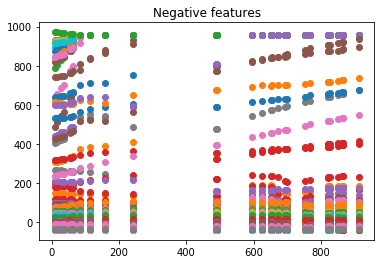

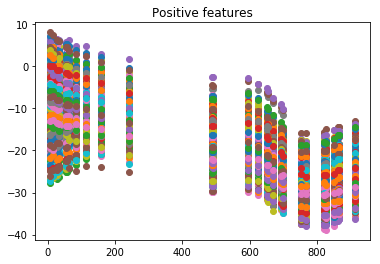

In [11]:
#--------------------------------------------------------------------------------Split Up Data

number_of_wavelengths = 30 # only even number
test_set_split = 0.1
number_of_values = 3
number_of_wavelengths = int(number_of_wavelengths / 2)

#maxGradients = np.array([], dtype=np.int)
#minGradients = np.array([], dtype=np.int)

# Stores maxum gradient change per wavelength over all data
maxGradients = {}
minGradients = {}

# Gradients per dataSet
for entry in np.concatenate([gradientData_new, gradientData_old]):
    g_max_ind = entry.argsort()[-number_of_values:][::-1][0]
    g_min_ind = entry.argsort()[:number_of_values][0]
    if g_max_ind in maxGradients:
        maxGradients[g_max_ind] = max(maxGradients[g_max_ind], entry[g_max_ind])
    else:
        maxGradients[g_max_ind] = entry[g_max_ind]
    if g_min_ind in minGradients:
        minGradients[g_min_ind] = min(minGradients[g_min_ind], entry[g_min_ind])
    else:
        minGradients[g_min_ind] = entry[g_min_ind]
    #maxGradients = np.append(maxGradients, entry.argsort()[-number_of_values:][::-1])
    #minGradients = np.append(minGradients, entry.argsort()[:number_of_values])

maxGradients = sorted(maxGradients.items(), key=lambda kv: kv[1])
minGradients = sorted(minGradients.items(), key=lambda kv: kv[1])

maxGradients = maxGradients[0:number_of_wavelengths]
minGradients = minGradients[0:number_of_wavelengths]

# Only keep wavelength
maxGradients = [row[0] for row in maxGradients]
minGradients = [row[0] for row in minGradients]

smallXValues = np.append(maxGradients,minGradients,axis=0)
    
# Remove duplicate wavelenghts
smallXValues = np.unique(smallXValues)
print("Wavelengths to use for further operations:", smallXValues, "nm.")
print("In total: ", len(smallXValues), " wavelengths.")

# Small features = only wavelengths where gradient is max or min
smallFeaturesPositive = np.concatenate([dataPositivesOld[:,smallXValues], dataPositivesNew[:,smallXValues]])
#smallFeaturesPositive = np.tile(smallFeaturesPositiveReal,(28,1)) #Increase positives to deal with unbalance class
smallFeature = np.concatenate([dataNegativesOld[:,smallXValues], dataNegativesNew[:,smallXValues]])

#[1,0] is dead, [0.1] alive
#CompleteSet Small Version
compSet = np.append(smallFeature, smallFeaturesPositive ,axis=0)
classifcSet = np.append(np.tile([1,0],(smallFeature.shape[0],1)),np.tile([0,1],(smallFeaturesPositive.shape[0],1)),axis=0)

#shuffle data together
mix = np.random.permutation(len(compSet))
compSet = compSet[mix]
classifcSet = classifcSet[mix]

#Split in training and test Data
#trainingSet = compSet[:200]
#trainingLabelSet =  classifcSet[:200]

training_set_split = int(compSet.shape[0] * (1 - test_set_split))
trainingSet = compSet[:training_set_split]
trainingLabelSet =  classifcSet[:training_set_split]

#validationSet = compSet[200:300]
#validationLabelSet = classifcSet[200:300]

testSet = compSet[training_set_split + 1:]
testLabelSet = classifcSet[training_set_split + 1:]

plottSpectrals(smallXValues,smallFeature, "Negative features", "o")
plottSpectrals(smallXValues,smallFeaturesPositive, "Positive features", "o")

In [12]:
  # Memory usage
# https://stackoverflow.com/questions/43137288/how-to-determine-needed-memory-of-keras-model

def get_model_memory_usage(batch_size, model):
    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [13]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
#    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#        plt.text(j, i, format(cm[i, j], fmt),
#                 horizontalalignment="center",
#                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 5)                 155       
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 12        
Total params: 167
Trainable params: 167
Non-trainable params: 0
_________________________________________________________________

165/165 [==============================] - 0s 400us/step
Positives in testset =  113
Negatives in testset =  52
loss :  0.09672599958650993
acc :  0.9696969696969697
Confusion matrix, without normalization
[[ 49   3]
 [  2 111]]


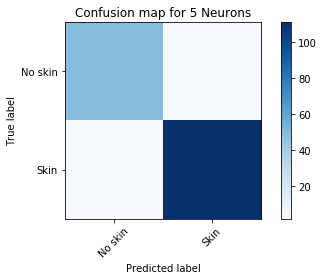

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 22        
Total params: 332
Trainable params: 332
Non-trainable params: 0
_________________________________________________________________

165/165 [==============================] - 0s 455us/step
Positives in testset =  113
Negatives in testset =  52
loss :  10.978285644993637
acc :  0.3151515153321353
Confusion matrix, without normalization
[[ 52   0]
 [113   0]]


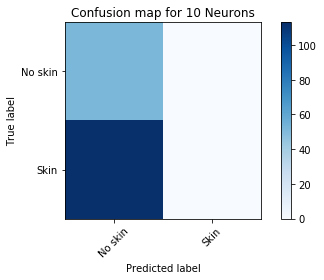

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 32        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________

165/165 [==============================] - 0s 461us/step
Positives in testset =  113
Negatives in testset =  52
loss :  0.10774596631526948
acc :  0.9878787878787879
Confusion matrix, without normalization
[[ 52   0]
 [  2 111]]


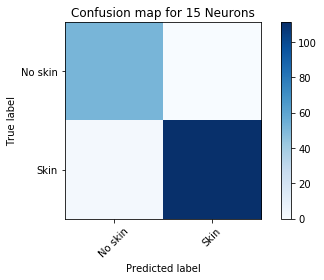

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 42        
Total params: 662
Trainable params: 662
Non-trainable params: 0
_________________________________________________________________

165/165 [==============================] - 0s 485us/step
Positives in testset =  113
Negatives in testset =  52
loss :  0.039893839629649215
acc :  0.9818181818181818
Confusion matrix, without normalization
[[ 50   2]
 [  1 112]]


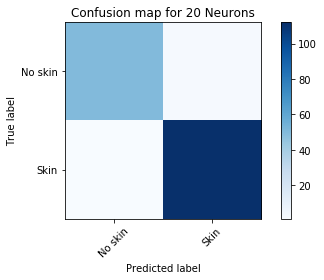

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 50)                1550      
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 102       
Total params: 1,652
Trainable params: 1,652
Non-trainable params: 0
_________________________________________________________________

165/165 [==============================] - 0s 491us/step
Positives in testset =  113
Negatives in testset =  52
loss :  0.11544843520916237
acc :  0.9696969696969697
Confusion matrix, without normalization
[[ 47   5]
 [  0 113]]


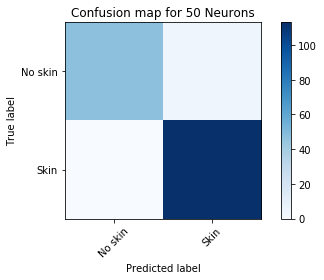

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 202       
Total params: 3,302
Trainable params: 3,302
Non-trainable params: 0
_________________________________________________________________

165/165 [==============================] - 0s 512us/step
Positives in testset =  113
Negatives in testset =  52
loss :  0.05784796128105937
acc :  0.9818181818181818
Confusion matrix, without normalization
[[ 50   2]
 [  1 112]]


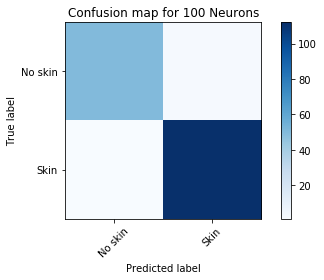

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 500)               15500     
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 1002      
Total params: 16,502
Trainable params: 16,502
Non-trainable params: 0
_________________________________________________________________

165/165 [==============================] - 0s 546us/step
Positives in testset =  113
Negatives in testset =  52
loss :  0.07351485591268901
acc :  0.9757575757575757
Confusion matrix, without normalization
[[ 51   1]
 [  3 110]]


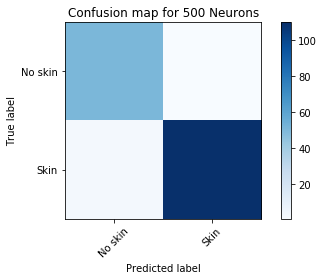

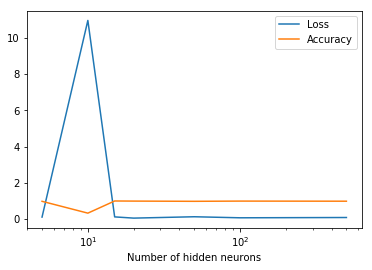

In [18]:
#--------------------------------------------------------------------------------Build Model with tensorflow
from timeit import default_timer as timer

hidden_neuron_size = [5,10,15,20,50,100,500]
number_of_runs = 100 # For determination of timing
batch_size = 10
loss_array = []
acc_array = []

time_effort = {}
memory_usage = {}

model_history_dict = {}

for number_of_hidden_neurons in hidden_neuron_size:
    from tensorflow.keras import backend as K

    model = keras.Sequential() #Single input-output
    model.add(keras.layers.Dense(number_of_hidden_neurons, activation=tf.nn.relu, input_shape=(trainingSet.shape[1],))) #fully-conndected = dense, with 16 units, relu: rectified linear unit
    model.add(keras.layers.Dense(2, activation=tf.nn.softmax)) #Cofidence level

    model.summary()

    #Optimizer and loss function
    model.compile(optimizer=tf.train.AdamOptimizer(), #or sgd(stochastic gradient descent optimizer: keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
                  loss='binary_crossentropy', #or mean_squared_error (our target is not in the continuos space), but binary seems to deal better with probabilitis
                  #loss=weighted_binary_crossentropy,
                  metrics=['accuracy']
                  )


    #Weighted class did not solve the unequal class problem
    #[1,0] is dead, [0.1] alive

    # Create sample weights
    # Make positive samples count more
    weights = []
    for index, entry in enumerate(trainingSet):
        if trainingLabelSet[index][0] == 0:
            weights.append(1)
        else:
            weights.append(2)
    weights = np.array(weights)

    #class_weight=[3, .5]

    #Train model for 50 epochs in batches of 3 samples
    history = model.fit(trainingSet,
                        trainingLabelSet,
                        epochs=50,
                        batch_size=batch_size,  #the bigger the more memory space needed
                        validation_split=0.2,
                        #verbose=1,
                        verbose=0,
                        sample_weight=weights,
                        #class_weight=class_weight
                        )

    model_history_dict[number_of_hidden_neurons] = history
    print()
    results = model.evaluate(testSet, testLabelSet)
    positive = 0
    negative = 0
    for entry in testLabelSet:
        if entry[0] == 0:
            positive += 1
        else:
            negative += 1

    print("Positives in testset = ", positive)
    print("Negatives in testset = ", negative)

    for index, metric in enumerate(model.metrics_names):
        print(metric, ": ", results[index])
        # Loss
        if index == 0:
            loss_array.append(results[index])
        else:
            acc_array.append(results[index])
            

    # Creating the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(testSet)
    y_test = testLabelSet
    
    # Confusion map
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.round().argmax(axis=1))
    plot_confusion_matrix(cm, ["No skin", "Skin"], title="Confusion map for " + str(number_of_hidden_neurons) + " Neurons")
    
    # Generate timing data:
    timer_arr = []
    for i in range(0, number_of_runs):
        start = timer()
        result = model.predict(smallFeature)
        end = timer()
        us = (end - start) / 10e6
        timer_arr.append(us)
    us = np.average(timer_arr)
    time_effort[number_of_hidden_neurons] = us
    
    # Timing
    memory_usage[number_of_hidden_neurons] = get_model_memory_usage(batch_size, model)

plt.plot(hidden_neuron_size, loss_array, label="Loss")
plt.plot(hidden_neuron_size, acc_array, label="Accuracy")
plt.xlabel("Number of hidden neurons")
plt.legend()
plt.xscale('log')

5 hidden neurons


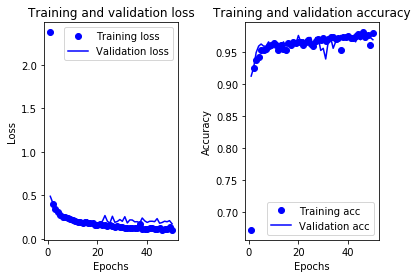

10 hidden neurons


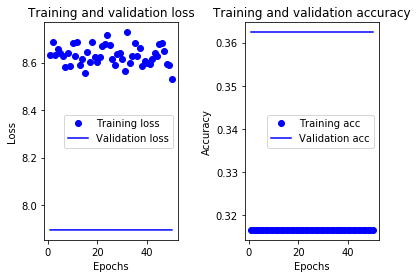

15 hidden neurons


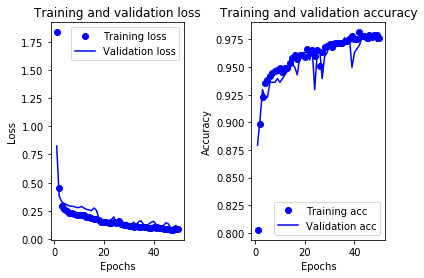

20 hidden neurons


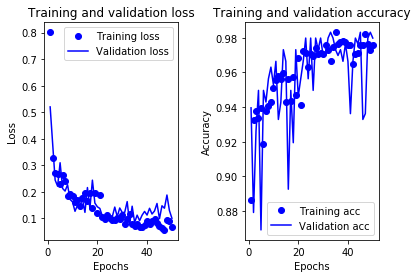

50 hidden neurons


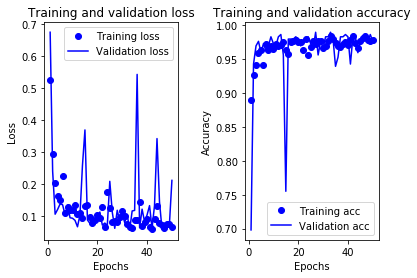

100 hidden neurons


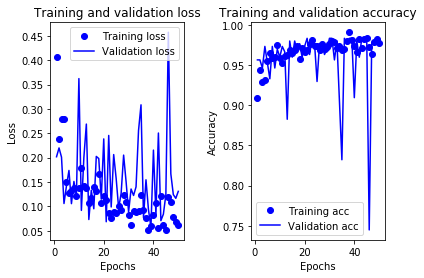

500 hidden neurons


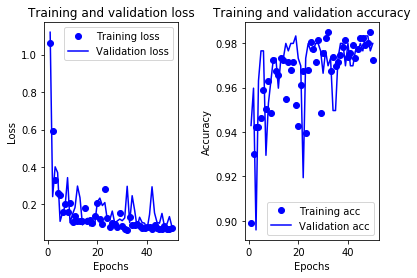

In [27]:
#--------------------------------------------------------------------------------Print Results
for item in model_history_dict.items():
    #Plot accuracy and loss over time
    number_of_hidden_neurons = item[0]
    history = item[1]
    history_dict = history.history
    history_dict.keys()

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    print(str(number_of_hidden_neurons) + " hidden neurons")
    plt.subplot(1,2,1)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.subplots_adjust(wspace=0.5)

    #plt.clf()   # clear figure
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

[]

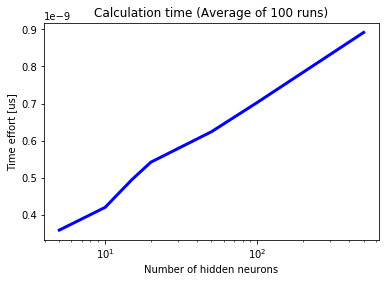

In [16]:
# ----------------------------------------------------Some Time estimation
x_arr = []
y_arr = []
for item in time_effort.items():
    x_arr.append(item[0])
    y_arr.append(item[1])
plt.plot(x_arr, y_arr, 'b', lw=3)
plt.xlabel('Number of hidden neurons')
plt.ylabel('Time effort [us]')
plt.title("Calculation time (Average of " + str(number_of_runs) + " runs)")
plt.xscale('log')
plt.plot()

[]

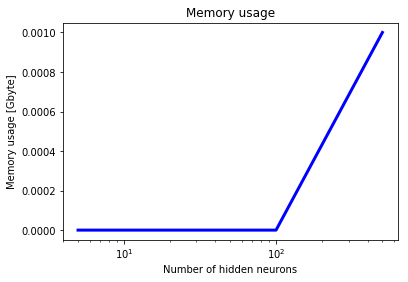

In [17]:
# ----------------------------------------------------Some Time estimation
x_arr = []
y_arr = []
for item in memory_usage.items():
    x_arr.append(item[0])
    y_arr.append(item[1])
plt.plot(x_arr, y_arr, 'b', lw=3)
plt.xlabel('Number of hidden neurons')
plt.ylabel('Memory usage [Gbyte]')
plt.title("Memory usage")
plt.xscale('log')
plt.plot()